ACISpy provides the ability to run [Xija](http://cxc.cfa.harvard.edu/mta/ASPECT/tool_doc/xija/index.html) thermal models via a special class, `ThermalModelRunner`. It takes as input an initial temperature, a dictionary of commanded states, and starting and stopping times for the model. The nice thing about `ThermalModelRunner` is that it is actually a `Dataset` object, so we can look at the different fields, make plots, and create derived fields.

In [1]:
from acispy import SimulateECSRun, ThermalModelRunner, DatePlot
import numpy as np

## Running Thermal Models

For simplicity, we'll pick constant states except change the CCD count.

In [2]:
states = {"ccd_count": np.array([5,6,1]),
          "pitch": np.array([150.0]*3),
          "fep_count": np.array([5,6,1]),
          "clocking": np.array([1]*3),
          "vid_board": np.array([1]*3),
          "off_nominal_roll": np.array([0.0]*3),
          "simpos": np.array([-99616.0]*3),
          "datestart": np.array(["2015:002:00:00:00","2015:002:12:00:00","2015:003:12:00:00"]),
          "datestop": np.array(["2015:002:12:00:00","2015:003:12:00:00","2015:005:00:00:00"])}

Now decide on an initial temperature:

In [3]:
Tinit = 13.0 # in degrees C

Now we'll create a `ThermalModelRunner` class given all of this information. The first argument has to be the model we want to run, `"dea"`, `"dpa"`, or `"psmc"`, and the second and third arguments have to be the beginning time and ending time of the thermal model: 

In [4]:
dea_model = ThermalModelRunner("1deamzt", "2015:002:00:00:00", "2015:005:00:00:00", states=states, T_init=Tinit)

We can now access the model data and states and make plots of them just as we can with any other `Dataset` object:

In [5]:
print(dea_model["model","1deamzt"][:10])

[13.         13.42945269 13.64285144 14.05660002 14.26219526 14.66081404
 14.85889115 15.24293341 15.43376733 15.80376615] deg_C


In [6]:
dp = DatePlot(dea_model, ("model","1deamzt"), field2="ccd_count")
dp.set_ylim2(0,7)
dp

We can also dump the results of the model run to disk, both the states and the model components:

In [7]:
dea_model.write_model("model.dat", overwrite=True)
dea_model.write_states("states.dat", overwrite=True)

These files can be loaded in at a later date using `ModelDataFromFiles`.

## Running a Thermal Model from a `states.dat` file

One can also run a thermal model from a `states.dat` table file which would be outputted by the thermal model check scripts during a load review, using the `from_states_table()` method (it is still necessary to supply start and stop times and an initial temperature):

In [8]:
tstart = "2015:002:00:00:00"
tstop = "2015:003:00:00:00"
T_init = 34.71

In [9]:
dpa_model = ThermalModelRunner.from_states_table("1dpamzt", tstart, tstop, "states.dat", T_init)

## Running Thermal Models Using Real-Life Data

If you want to use the commanded states database and the engineering archive as inputs for a model run, use the special class `ThermalModelFromData`, which will take MSIDs and states from the engineering archive and run a model using them. We simply need to specify the start and stop times of the model and which model to run. If we want to take model "bad times" into account, we also need to set `include_bad_times=True`:

In [10]:
dpa_model = ThermalModelRunner("1dpamzt", "2015:074:12:05:00.100", "2015:080:13:07:45.234", include_bad_times=True)

This can be used to plot MSID and model data simultaneously:

In [11]:
dp = DatePlot(dpa_model, [("msids", "1dpamzt"), ("model", "1dpamzt")], plot_bad=True)
dp

Note that for this period of time a segment of it was marked as a "bad time" in the model, and this shows up in the cyan region in the plot. 

## Making Dashboard Plots

### NOTE: This functionality requires the `xijafit` package to be installed. 

It is possible to use the thermal model objects and the `xijafit` package to make dashboard plots. For this, use the `make_dashboard_plots()` method:

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


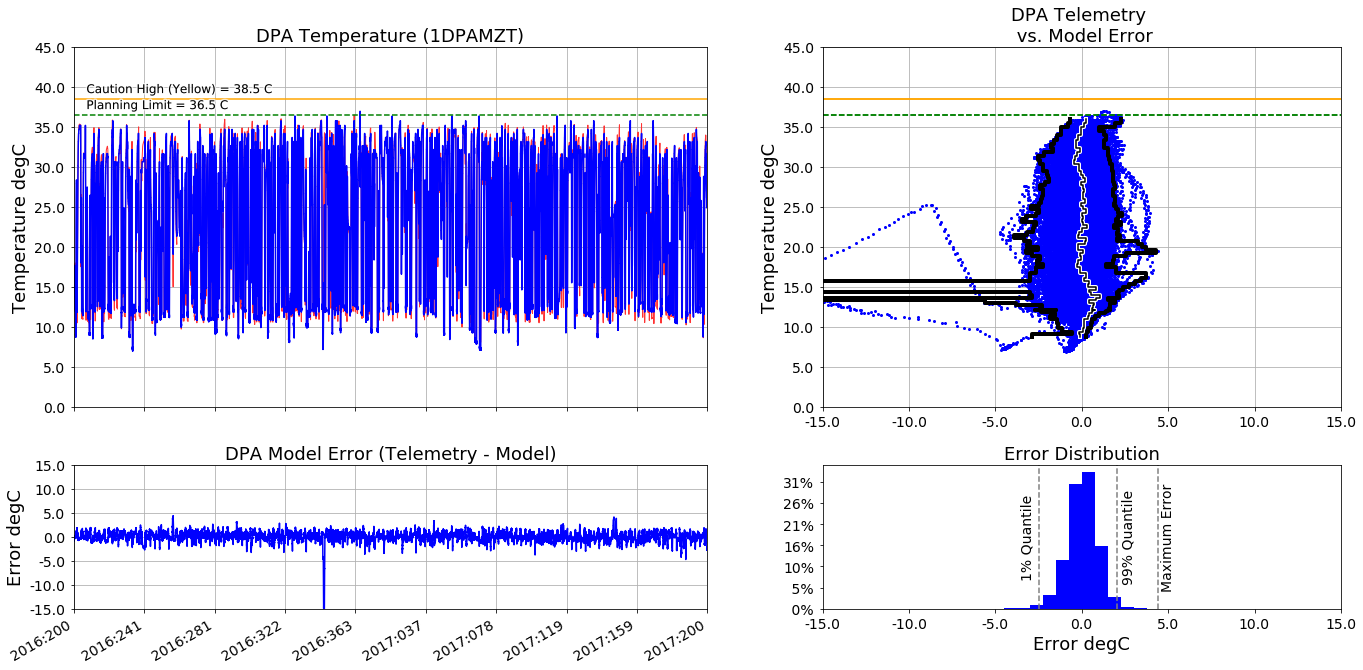

In [12]:
dpa_model_long = ThermalModelRunner("1dpamzt", "2016:200", "2017:200", include_bad_times=True)
dpa_model_long.make_dashboard_plots(figfile="my_dpa_dash.png")

`figfile` sets the filename to save the dashboard plot to.

One can also use the `errorplotlimits` and `yplotlimits` arguments to set the bounds of the temperature and the errors on the plots:

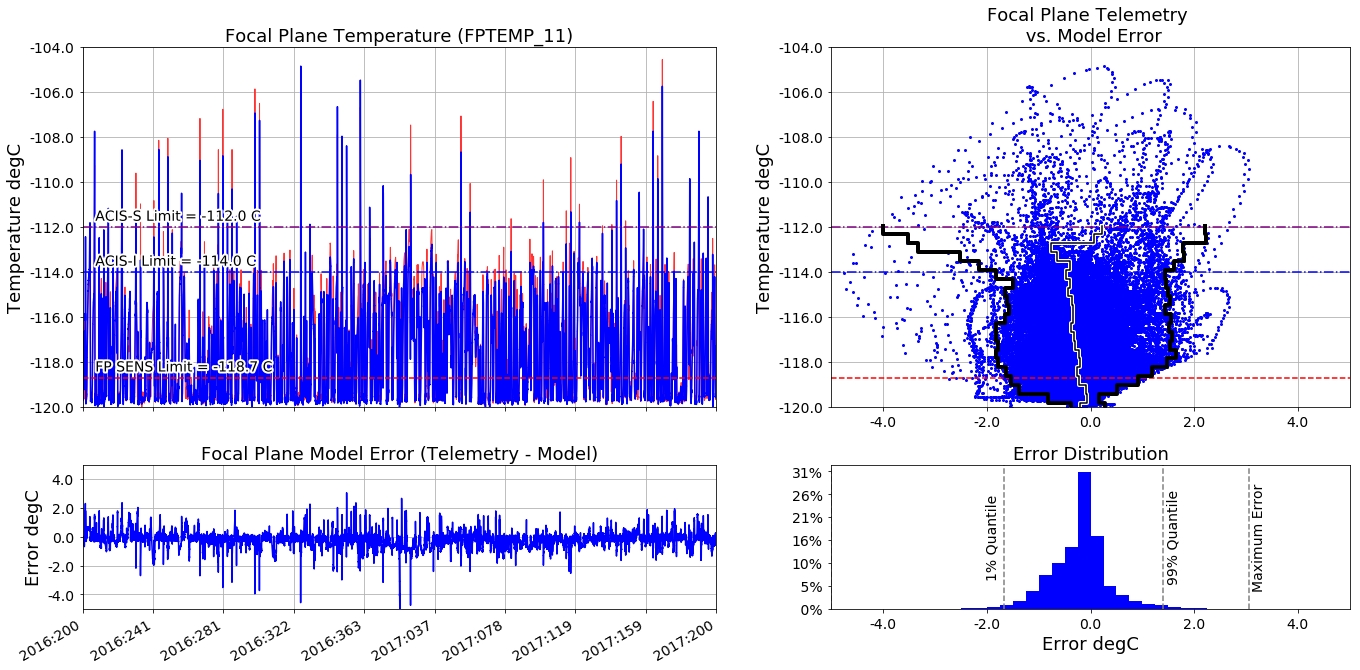

In [13]:
fp_model_long = ThermalModelRunner("fptemp_11", "2016:200", "2017:200", include_bad_times=True)
fp_model_long.make_dashboard_plots(yplotlimits=(-120.0, -105.0), errorplotlimits=(-5.0, 5.0))

For the focal plane model, it may be better to mask out the radzones, since we don't care about violations of the thermal limits when we are not observing in this case. We can do this by setting `mask_radzones=True`:

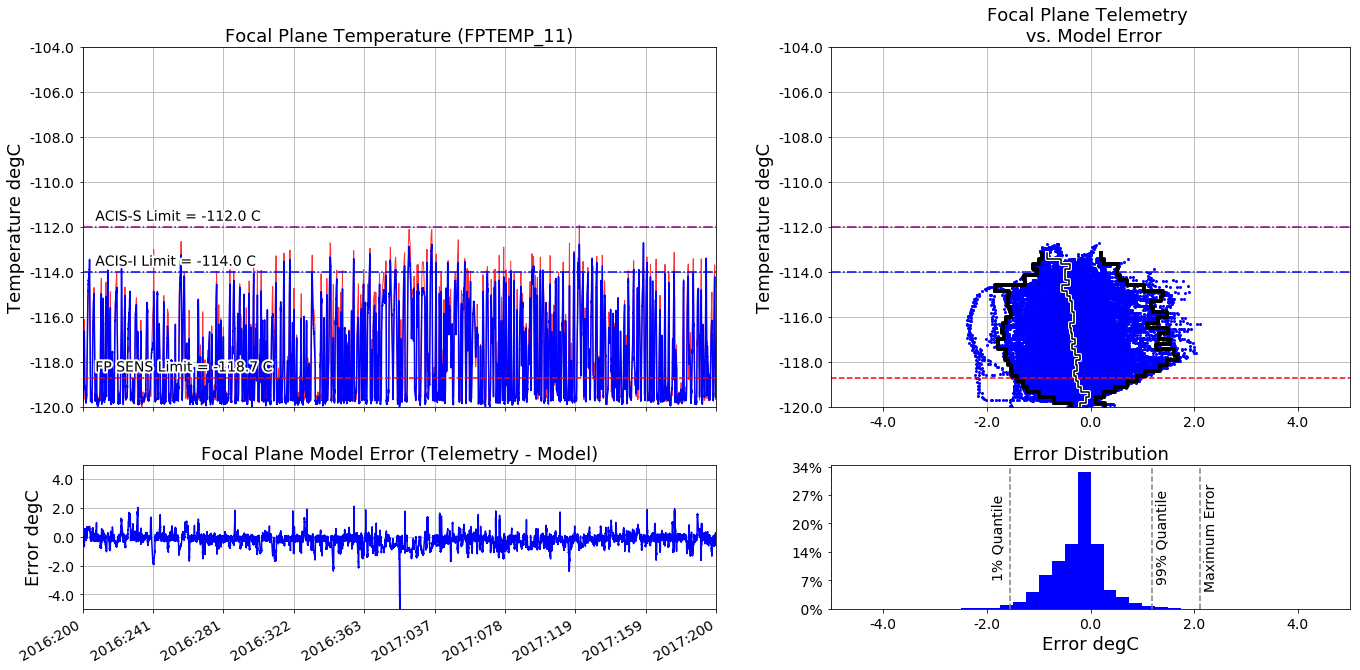

In [14]:
fp_model_long.make_dashboard_plots(mask_radzones=True, yplotlimits=(-120.0, -105.0), 
                                   errorplotlimits=(-5.0, 5.0))

## Plotting Pitch Heating Values

All of the ACIS thermal models have a solar heating component. 

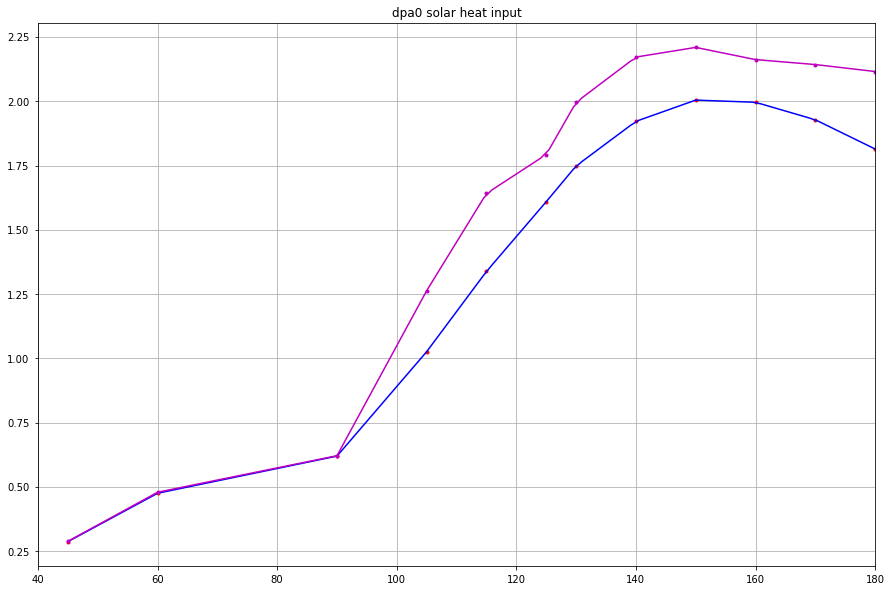

In [15]:
dpa_model_long.make_solarheat_plot("dpa0", figfile="dpa0_pitches.png")

## Simulating ECS Runs

A special case of running a thermal model in ACISpy is simulating an ECS run, which may be performed after a safing action. The `SimulateECSRun` class simplifies the call to `ThermalModelRunner` by assuming that the state is constant over a period of time (unless a vehicle load is running, see below). The goal is to predict if the temperature will hit the planning limit within the time frame of the ECS run.
To run this model, we only need specify a few parameters (some of which are optional and have default values):

In [16]:
pitch = 150. # in degrees
T_init = 7.5 # in degrees C
ccd_count = 6 # number of CCDs
simpos = -99616.0 # SIM-Z position, optional, default -99616.0
off_nominal_roll = 0.0 # in degrees, optional, default 0.0
dh_heater = 0 # is the detector housing heater on (1) or off (0)? default 0

We pick a model to run (most relevant is `"dpa"`) along with a start time and a stop time, and feed them and the above parameters into `SimulateECSRun`:

In [17]:
dpa_ecs_run = SimulateECSRun("1dpamzt", "2015:002:00:00:00", "2015:003:00:00:00", T_init, pitch, ccd_count, 
                             simpos=simpos, off_nominal_roll=off_nominal_roll, dh_heater=dh_heater)

acispy: [INFO     ] 2019-02-08 16:36:42,276 Run Parameters
acispy: [INFO     ] 2019-02-08 16:36:42,277 --------------
acispy: [INFO     ] 2019-02-08 16:36:42,278 Start Datestring: 2015:002:00:00:00.000
acispy: [INFO     ] 2019-02-08 16:36:42,279 Stop Datestring: 2015:003:00:00:00.000
acispy: [INFO     ] 2019-02-08 16:36:42,280 Initial Temperature: 7.5 degrees C
acispy: [INFO     ] 2019-02-08 16:36:42,280 CCD Count: 6
acispy: [INFO     ] 2019-02-08 16:36:42,281 Pitch: 150.0
acispy: [INFO     ] 2019-02-08 16:36:42,282 SIM Position: -99616
acispy: [INFO     ] 2019-02-08 16:36:42,283 Off-nominal Roll: 0.0
acispy: [INFO     ] 2019-02-08 16:36:42,284 Detector Housing Heater: OFF
acispy: [INFO     ] 2019-02-08 16:36:42,285 Model Result
acispy: [INFO     ] 2019-02-08 16:36:42,286 ------------
acispy: [INFO     ] 2019-02-08 16:36:42,287 The limit of 36.5 degrees C will be reached at 2015:002:10:41:52.816, after 38.5128 ksec.
acispy: [INFO     ] 2019-02-08 16:36:42,288 The limit is reached befor

The run reports back the input parameters and the time when the limit was reached, if it was at all. We can plot the model using the `plot_model()` method, 
which shows the limit value as a dashed green line and the time at which the limit was reached as a dashed red line:

In [18]:
dp = dpa_ecs_run.plot_model()

In this case, if the pitch had been a little smaller, the limit would be reached _after_ the ECS run, so this is safe.

In [19]:
pitch = 142.0
dpa_ecs_run = SimulateECSRun("1dpamzt", "2015:002:00:00:00", "2015:003:00:00:00", T_init, pitch, ccd_count, 
                             simpos=simpos, off_nominal_roll=off_nominal_roll, dh_heater=dh_heater)
dp = dpa_ecs_run.plot_model()

acispy: [INFO     ] 2019-02-08 16:36:42,691 Run Parameters
acispy: [INFO     ] 2019-02-08 16:36:42,692 --------------
acispy: [INFO     ] 2019-02-08 16:36:42,693 Start Datestring: 2015:002:00:00:00.000
acispy: [INFO     ] 2019-02-08 16:36:42,693 Stop Datestring: 2015:003:00:00:00.000
acispy: [INFO     ] 2019-02-08 16:36:42,694 Initial Temperature: 7.5 degrees C
acispy: [INFO     ] 2019-02-08 16:36:42,695 CCD Count: 6
acispy: [INFO     ] 2019-02-08 16:36:42,696 Pitch: 142.0
acispy: [INFO     ] 2019-02-08 16:36:42,696 SIM Position: -99616
acispy: [INFO     ] 2019-02-08 16:36:42,697 Off-nominal Roll: 0.0
acispy: [INFO     ] 2019-02-08 16:36:42,698 Detector Housing Heater: OFF
acispy: [INFO     ] 2019-02-08 16:36:42,699 Model Result
acispy: [INFO     ] 2019-02-08 16:36:42,700 ------------
acispy: [INFO     ] 2019-02-08 16:36:42,701 The limit of 36.5 degrees C will be reached at 2015:002:17:48:16.816, after 64.0968 ksec.
acispy: [INFO     ] 2019-02-08 16:36:42,702 The limit is reached befor

Note that for some combinations of parameters the limit may never be reached. For example, let's knock the CCD count down to 4:

In [20]:
ccd_count = 4 # only 4 CCDs
dpa_ecs_run = SimulateECSRun("1dpamzt", "2015:002:00:00:00", "2015:003:00:00:00", T_init, pitch, ccd_count, 
                             simpos=simpos, off_nominal_roll=off_nominal_roll, dh_heater=dh_heater)
dp = dpa_ecs_run.plot_model()

acispy: [INFO     ] 2019-02-08 16:36:43,008 Run Parameters
acispy: [INFO     ] 2019-02-08 16:36:43,009 --------------
acispy: [INFO     ] 2019-02-08 16:36:43,010 Start Datestring: 2015:002:00:00:00.000
acispy: [INFO     ] 2019-02-08 16:36:43,011 Stop Datestring: 2015:003:00:00:00.000
acispy: [INFO     ] 2019-02-08 16:36:43,012 Initial Temperature: 7.5 degrees C
acispy: [INFO     ] 2019-02-08 16:36:43,012 CCD Count: 4
acispy: [INFO     ] 2019-02-08 16:36:43,013 Pitch: 142.0
acispy: [INFO     ] 2019-02-08 16:36:43,014 SIM Position: -99616
acispy: [INFO     ] 2019-02-08 16:36:43,015 Off-nominal Roll: 0.0
acispy: [INFO     ] 2019-02-08 16:36:43,016 Detector Housing Heater: OFF
acispy: [INFO     ] 2019-02-08 16:36:43,017 Model Result
acispy: [INFO     ] 2019-02-08 16:36:43,018 ------------
acispy: [INFO     ] 2019-02-08 16:36:43,019 The limit of 36.5 degrees C is never reached.
acispy: [INFO     ] 2019-02-08 16:36:43,020 This observation is safe from a thermal perspective.


### Simulating ECS Runs with Vehicle Loads

If the spacecraft executed SCS-107, we may be running an ECS run while the vehicle load is still running, which means that the pitch and off-nominal roll may change during the ECS run. If this is the case, pass the name of the load to the ``vehicle_load`` parameter. You still need to input the value of the ``pitch`` parameter, but the value of this parameter and that of the ``off_nominal_roll`` optional parameter will be ignored in favor of the value in the vehicle load. An example of an ECS run that is not safe:

In [21]:
pitch = 0.0 # Doesn't matter what this is
T_init = 12.0 # in degrees C
ccd_count = 6 # number of CCDs 
dpa_ecs_run = SimulateECSRun("1dpamzt", "2017:256:03:20:00", "2017:257:15:20:00", T_init, pitch, ccd_count, 
                             vehicle_load="SEP0917C")
dp = dpa_ecs_run.plot_model()

acispy: [INFO     ] 2019-02-08 16:36:43,302 Modeling a 6-chip observation concurrent with the SEP0917C vehicle loads.
acispy: [INFO     ] 2019-02-08 16:36:44,358 Run Parameters
acispy: [INFO     ] 2019-02-08 16:36:44,359 --------------
acispy: [INFO     ] 2019-02-08 16:36:44,360 Start Datestring: 2017:256:03:20:00.000
acispy: [INFO     ] 2019-02-08 16:36:44,360 Stop Datestring: 2017:257:15:20:00.000
acispy: [INFO     ] 2019-02-08 16:36:44,361 Initial Temperature: 12 degrees C
acispy: [INFO     ] 2019-02-08 16:36:44,362 CCD Count: 6
acispy: [INFO     ] 2019-02-08 16:36:44,363 Pitch: Min: 46.56, Max: 156
acispy: [INFO     ] 2019-02-08 16:36:44,364 SIM Position: -99616
acispy: [INFO     ] 2019-02-08 16:36:44,365 Off-nominal Roll: Min: -12.5116, Max: 13.7689
acispy: [INFO     ] 2019-02-08 16:36:44,366 Detector Housing Heater: OFF
acispy: [INFO     ] 2019-02-08 16:36:44,366 Model Result
acispy: [INFO     ] 2019-02-08 16:36:44,367 ------------
acispy: [INFO     ] 2019-02-08 16:36:44,368 The 

But if we drop it down to 5 chips, it is safe:

In [22]:
ccd_count = 5 # number of CCDs 
dpa_ecs_run = SimulateECSRun("1dpamzt", "2017:256:03:20:00", "2017:257:15:20:00", T_init, pitch, ccd_count, 
                             vehicle_load="SEP0917C")
dp = dpa_ecs_run.plot_model()

acispy: [INFO     ] 2019-02-08 16:36:44,877 Modeling a 5-chip observation concurrent with the SEP0917C vehicle loads.
acispy: [INFO     ] 2019-02-08 16:36:45,754 Run Parameters
acispy: [INFO     ] 2019-02-08 16:36:45,755 --------------
acispy: [INFO     ] 2019-02-08 16:36:45,755 Start Datestring: 2017:256:03:20:00.000
acispy: [INFO     ] 2019-02-08 16:36:45,756 Stop Datestring: 2017:257:15:20:00.000
acispy: [INFO     ] 2019-02-08 16:36:45,757 Initial Temperature: 12 degrees C
acispy: [INFO     ] 2019-02-08 16:36:45,758 CCD Count: 5
acispy: [INFO     ] 2019-02-08 16:36:45,759 Pitch: Min: 46.56, Max: 156
acispy: [INFO     ] 2019-02-08 16:36:45,760 SIM Position: -99616
acispy: [INFO     ] 2019-02-08 16:36:45,761 Off-nominal Roll: Min: -12.5116, Max: 13.7689
acispy: [INFO     ] 2019-02-08 16:36:45,761 Detector Housing Heater: OFF
acispy: [INFO     ] 2019-02-08 16:36:45,762 Model Result
acispy: [INFO     ] 2019-02-08 16:36:45,763 ------------
acispy: [INFO     ] 2019-02-08 16:36:45,764 The 